# Sync overview

The feature service includes a `Sync` capability, which when enabled, allows client applications to take feature layers offline, perform edits and sync it back with the service. When you checkout some features and store it offline in the client, you call that a `replica`. The `FeatureLayerCollection` class under the `features` module allows users to create and work with replicas. The workflow of using sync involves these three operations:
- Create replica
- Synchronize replica
- Unregister replica

To learn more about this feature, refer to the [documentation here](http://resources.arcgis.com/en/help/arcgis-rest-api/index.html#//02r300000112000000)

## Checking out data from feature layers using replicas
To create a replica, we need a feature service with sync enabled. We can use the `syncEnabled` property of a `FeatureLayer` object to verify that. Further the `syncCapabilities` property returns a dictionary with fine grained sync capabilities

In [2]:
# connect to a GIS
from arcgis.gis import GIS
import arcgis.features
gis = GIS() #connect to www.arcgis.com anonymously. 
             #We will use a public sync enabled feature service

To create and work with replicas, we need to create a `FeatureLayerCollection` object. A `FeatureLayerCollection` object can be created from either a feature service `Item` or directly using a feature service url.

Here, we will connect to a sample service by esri with url `https://sampleserver6.arcgisonline.com/arcgis/rest/services/Sync/WildfireSync/FeatureServer/` 

In [3]:
url = 'https://sampleserver6.arcgisonline.com/arcgis/rest/services/Sync/WildfireSync/FeatureServer/'
wildfire_flc = arcgis.features.FeatureLayerCollection(url, gis)

In [4]:
type(wildfire_flc)

arcgis.features.layer.FeatureLayerCollection

### Verify if sync is enabled

Accessing the `layers` property on a `FeatureLayerCollection` returns a list of `FeatureLayer` objects. We can create a replica of one of these or all of these layers

In [5]:
wildfire_flc.layers

[<FeatureLayer url:"https://sampleserver6.arcgisonline.com/arcgis/rest/services/Sync/WildfireSync/FeatureServer//0">,
 <FeatureLayer url:"https://sampleserver6.arcgisonline.com/arcgis/rest/services/Sync/WildfireSync/FeatureServer//1">,
 <FeatureLayer url:"https://sampleserver6.arcgisonline.com/arcgis/rest/services/Sync/WildfireSync/FeatureServer//2">]

In [7]:
# query syncEnabled property to verify is sync is enabled
wildfire_flc.properties.syncEnabled

True

In [8]:
# query the syncCapabilities property to view fine grained capabilities
wildfire_flc.properties.syncCapabilities

{
  "supportsRegisteringExistingData": true,
  "supportsPerReplicaSync": false,
  "supportsAttachmentsSyncDirection": true,
  "supportsPerLayerSync": true,
  "supportsRollbackOnFailure": false,
  "supportsSyncModelNone": true,
  "supportsSyncDirectionControl": true,
  "supportsAsync": true
}

### List existing replicas

The `replicas` property on a `FeatureLayerCollection` object returns you a `SyncManager` object. You would work with this manager object for all your sync workflows.

You can find if any replicas were created earlier on this sevice by calling `get_list()` method on the `SyncManager` object.

In [10]:
replica_list = wildfire_flc.replicas.get_list()
len(replica_list)

4255

As you can see, there are a plenty of replicas on this service. Let us view one of it

In [11]:
replica_list[0]

{'replicaID': '29406BC5-55C4-4B63-BD60-D9DB6EA28D6F',
 'replicaName': 'Ags_Fs_1466602474959'}

### Create a replica
Now, let us create our own replica of this feature service. The `create()` method accepts a number of parameters allowing to filter what you want to replicate and customize other options. For more information on this operation, refer to the [documentation here](http://resources.arcgis.com/en/help/arcgis-rest-api/index.html#//02r3000000rp000000).

The full capability of the sync operation allows you to check out data from a feature service, make edits and sync the deltas (changes) back to the server and update the features. This is popular in use cases which involves client applications such as ArcGIS Runtime or ArcGIS Desktop applications check out data, go offline (such as in areas where network connectivity is limited) and make edits, then synchronize the data back to the server and update the features. The capability allows multiple clients to do this in parallel, thus enabling a large data collection effort.

However if your purpose of a replica is only to check out the data (one directional), then you can verify if the `extract` capability is enabled on the the feature service and create a replica that is just meant for data check out. We will see this use case below:

In [12]:
# list all capabilities
wildfire_flc.properties.capabilities

'Create,Delete,Query,Sync,Update,Uploads,Editing'

This service has disabled 'Extract'. Hence let us search for a different service

In [13]:
portal_gis = GIS("https://dev003246.esri.com/portal", "arcgis_python_api", "sharing.1")
search_result = portal_gis.content.search("Ports along west coast", "Feature Service")

<Item title:"Ports along west coast" type:Feature Service owner:arcgis_python_api>
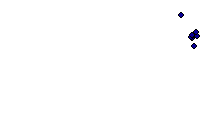

In [14]:
search_result[0]

Let us create a `FeatureLayerCollection` object from this item

In [15]:
ports_flc = arcgis.features.FeatureLayerCollection.fromitem(search_result[0])
type(ports_flc)

arcgis.features.layer.FeatureLayerCollection

#### Verify Extract capability

In [16]:
ports_flc.properties.capabilities

'Query,Editing,Create,Update,Delete,Sync,Extract'

This is a suitable feature service, let us extract the data into a file geodatabase and store it in local file system

In [23]:
ports_flc = arcgis.features.FeatureLayerCollection.fromitem(sr[0])

In [24]:
replica1 = ports_flc.replicas.create(replica_name = 'arcgis_python_api_2',
                                    layers='0',
                                    data_format='filegdb',
                                    out_path = 'E:\\demo')
replica1

'E:\\demo\\ad0dc00a447244f4b96aa39a30a4a093.zip'

Thus we were able to checkout data from this feature service into a file geodatabase. Clients can use this data in any way they wish, for instance, publish it as another feature service to a different portal or just store it for archival.